# Drug-Drug Similarity Based on Molecular Structure


                                                                                by Alberto Olivares Alarcos

This notebook gives a flavour of how to obtain a measurement of similarity between pairs of drugs considering their molecular structure. The measurement is computed using the fingerprint representation of both molecular structures, which are extracted from the database, DrugBank$^{[1]}$. The similarity matrix is used to cluster the drugs into 14 groups. An evaluation of those obtained clusters is done at the end of the experiment. 

Note that any time we talk about similarity, we are also talking about distance, since we can obtain one from the another one just substracting one of them to the unit (e.g. the similarity is one minus the distance, and vice-versa).

[1] *The DrugBank database is a comprehensive, freely accessible, online database containing information on drugs and drug targets. For more information visit: https://www.drugbank.ca/.*


## Experimental Setup

As said above, in this work we are going to compute a measure of similarity among drugs extracted from the Drugbank database. Our aim is to show how this measure could be useful, so that we use it to cluster the drugs. In this section, we explain the main parts of our experiment and the decision making done when choosing the tools used within this work.

### Why Molecular Structure?

Drugs are, essentially, chemical compounds. In the domain of chemical compounds, the chemical similarity plays an important role when designing new compounds since those compounds which share a similar structure have a similar biological activity. Although this hypothesis is not always valid, quite often the set of retrieved compounds is considerably enriched with actives.

In this project, we aim to exploit the capabilities of such a kind of similarity within our framework, a medical approach. 

### Data format

Drugbank database contains a lot of data which is rather heterogeneous, however, it is possible to download a complete database, written in XML, which includes all the fields for the covered drugs. For other experiments we have done in this project, it was better to use that generic file. Nevertheless, in this concrete experiment, we are using a specific file which is devoted to work with the molecular structure information of the drugs. 

In every Drugbank release there are several different documents to download (complete database, molecular structures, etc.). Thus, we can ensure that the drugs within the different documents are the same. This is just to clarify that we are using the same information than in the rest of performed experiments. Readers and users of this document could get confused about this, since in the present experiment we use more drugs than in others. The reason is that here we have used all the drugs which have a complete molecular structure, 8738 from a total of 10562 included in the used release.

The format of the file which contains the specific information related to Molecular Structures is SDF, which is one of a family of chemical-data file formats developed by MDL$^{[1]}$; it is intended especially for structural information. "SDF" stands for structure-data file, and SDF files actually wrap the molfile (MDL Molfile) format.  A feature of the SDF format is its ability to include associated data (not only molecular, but also general purpose data like 'drug id').

The reason why we decided to use this document was because we discovered there was a specific library for Python to deal with this sort of document. That tool (RDKit) was perfectly aligned to the work we wanted to do.

### RDKit

RDKit *(http://www.rdkit.org/)* is an Open source toolkit for cheminformatics and Machine Learning which contains a lot of methods and functionalities to deal with Molecular Structure data from chemical compounds (including similarity measures). It is written in Python (2 and 3) and has been used in several relevant open source projects (ChEMBL Beaker, myChEMBL, etc.).

The easiest and fastest way to use this tool is to install it using Conda. We have tried other sources but we strongly recommend to use the cited one. Within the project, we have included a description of the installation process we have followed to have our system working. We explain there how to install RDKit and prepare your computer to be able to run this notebook using a specific kernel (which has RDKit installed). 

Note that you could run the present notebook as long as the kernel you use has RDKit installed, so feel free to use other methods to install it. 

### Drugs representation

An important issue is how to actually represent the Molecular Structure of a chemical compound so that a computer can process it efficiently. Normally, the Molecular Structure is represented by well-known methods like: InChi Key or SMILES. However, we cannot use those sorts of representation to compute similarity between drugs. A more efficient representation is provided by fingerprints, a list of binary values (0 or 1) which characterize a molecule. In a nutshell, a Fingerprint represents a Molecular Structure by means of a binary vector in which each value corresponds to a fragment the molecule could contain. In the case that the molecule contains a fragment, the value in the fingerprint will be one. Obviously, the more bits we use, the more precise the representation is. In this project, we have explored two of the most well-known types: MACCS and ECFPs.

##### MACCS
 The MACCS keys are a set of questions about a chemical structure. Here are some of the questions:

    Are there fewer than 3 oxygens?
    Is there a S-S bond?
    Is there a ring of size 4?
    Is at least one F, Cl, Br, or I present?

The result of this is a list of binary values – either true (1) or false (0). This list of values for a given chemical structure is called the MACCS key fingerprint for that structure. 

##### ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. They are among the most popular similarity search tools in drug discovery and they are effectively used in a wide variety of applications.


The lenght for the fingerprints we are using in this project are: 167 bits for MACCS and 1024 bits for ECFP. This fact has an effect on the result of the computed similarities. The values of similarities when using MACCS are higher in general. ECFP has more precision (more bits) but that leads us to smaller values of similarity, obviously, the more bits we have, the more difficult is for the pairs of fingerprints to be similar. 

### Similarity Measure

The most popular similarity measure for comparing chemical structures represented by means of fingerprints is the Tanimoto (or Jaccard) coefficient (T). Two structures are usually considered similar if T > 0'85 (for Daylight fingerprints). However, it is a common misunderstanding that a similarity of T > 0'85 reflects similar bioactivities in general ("the 0'85 myth").

In this project we decided to use another sort of coefficient, Dice, however, we studied the correlation between the computed similarities using Dice and Tanimoto and it is around 0'9. Thus, we decided just to use Tanimoto for the clustering process.

### Clustering algorithm selection

There are a lot of clustering algorithms to choose from. In our case, we are working with Python, so that we could restrict the selection to those available among all Python libraries. The standard sklearn clustering suite has thirteen different clustering classes. 

The main aspect for us to take into account when choosing the proper algorithm is not different from any other problem in data science and machine learning: Data. Depending on the data we have and the format in which we have it, it will be more suitable to use one algorithm or another. In other experiments we have done, the data was textual and was represented into two different ways: matrix of samples (drugs) and features (tf-idf) and similarity/distance matrix. We could use any of the algorithms from *sklearn* library, however, in the current  experiment we do have a simiarity matrix, but not a matrix with samples and features. From the documentation of *sklearn* we have extracted the next paragrahp about the input data of the clustering algorithms:

One important thing to note is that the algorithms implemented in this module can take different kinds of matrix as input. All the methods accept standard data matrices of shape [n_samples, n_features]. These can be obtained from the classes in the sklearn.feature_extraction module. For AffinityPropagation, SpectralClustering and DBSCAN one can also input similarity matrices of shape [n_samples, n_samples]. These can be obtained from the functions in the sklearn.metrics.pairwise module.

Thus, just three options fit our experiment requirements: Affinity Propagation, Spectral Clustering and DBSCAN. We have chosen the Spectral Clustering algorihtm which is a good option for graph clustering, fact that we think fits our problem, since we are using a database which follows a graph structure (like a taxonomy). The only problem with this algorithm is the need of choosing the number of clusters. Nevertheless, that is something we could deal with since the data is structured in groups of drugs defined by several data fields. 

### Choosing the number of clusters

As said before, Drugbank database is structured forming different groups of drugs based on different characteristics: 

- Groups: Illicit, aproved, withdrawn, etc.
- Kingdoms: Organic and Inorganic.
- State: Solid, Liquid and Gas.
- ATC code: The Anatomical Therapeutic Chemical (ATC) Classification System is used for the classification of active ingredients of drugs according to the organ or system on which they act and their therapeutic, pharmacological and chemical properties.

In this work we use the ATC code.The system has a total of 5 levels, and the code consists of 7 alphanumerical characters, which can be read in the following way:

- First level: character 0 - for example ’A’
- Second level: characters 1-2, numbers - 02
- Third level: character 3 - for example ’C’
- Fourth level: character 4 - for example ’A’
- Fifth level: character 5-6 - for example 04

Although each level has it’s significance, we have decided to focus on the first one of
the system, which determines the anatomical main group and consists of 14 categories, as shown in the following Table:


|Code | Contents|
|-----|---------|
|A    | Alimentary tract and metabolism |
|B    | Blood and blood forming organs |
|C    | Cardiovascular system |
|D    | Dermatologicals |
|G    | Genito-urinary system and sex hormones | 
|H    | Systemic hormonal preparations, excluding sex hormones and insulins |
|J    | Antiinfectives for systemic use |
|L    | Antineoplastic and immunomodulating agents |
|M    | Musculo-skeletal system |
|N    | Nervous system |
|P    | Antiparasitic products, insecticides and repellents |
|R    | Respiratory system |
|S    | Sensory organs |
|V    | Various |



Therefore, the number of clusters we are going to use is fourteen, then, we will evaluate if actually this is a good decision.


[1] *MDL Information Systems, Inc. was a provider of R&D informatics products for the life sciences and chemicals industries. The company was launched as a computer-aided drug design firm (originally named Molecular Design Limited, Inc.) in January 1978 in Hayward, California..*

## IMPLEMENTATION

In [1]:
# Headers
import os
import sys
import scipy
import itertools
import gzip
import pandas
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
import rdkit.DataStructs
import time
import copy
import numpy
import matplotlib.pyplot as plt
from IPython.display import Image
import csv
from operator import itemgetter

from sklearn.cluster import SpectralClustering 

HERE = os.path.abspath(os.path.dirname("__file__"))
sys.path.append(os.path.join(HERE, ".."))

from utils.general_utils import *
from utils.molecular_structure_utils import *
from utils.evaluation_utils import *

print("Done")

Done


In [2]:
# Read SDF File and generate a dictionary of Drugbank IDs
file = './../corpus/structures.sdf' # Version 5.0.11
supplier = rdkit.Chem.SDMolSupplier(file)

molecules = [mol for mol in supplier if mol is not None]

ids = []
for mol in molecules:
    ids.append(mol.GetProp('DATABASE_ID'))
ids_dic = dict(enumerate(ids))

len(molecules)

8738

In [10]:
# Dictionary of drugs and their respective atc codes
if not(os.path.exists('./../data/molecular_structure/drug_atc_dict.pkl')):
    zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
    filename = 'drugbank.xml'

    file = read_zip_file(zip_filepath, filename)
    drug_atc_dict = drugbank_id_atc_dictionary(file)

    save_obj(drug_atc_dict, './../data/molecular_structure/', 'drug_atc_dict')
else:
    drug_atc_dict = load_obj('./../data/molecular_structure/', 'drug_atc_dict')

In [31]:
amog = (list(drug_atc_dict.values()))

contador = 0
for l in amog:
    if not(l):
        contador += 1
print(contador)

8275


In [32]:
conti = 0
for db_id in ids:
    atc_codes_dbid = drug_atc_dict[db_id]
    if atc_codes_dbid:
        conti += 1
print(conti) # Drugs from our expriment which actually has a atc code (for the indirect evaluation)

2003


Total ATC:  3512


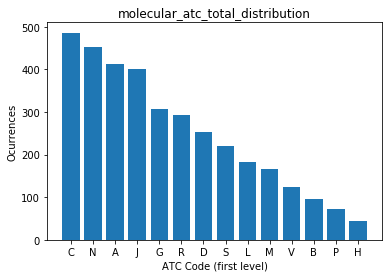

In [4]:
# Distribution of ATC Codes first level of the total set of used drugs
    
atc_first_level_all_drugs = list()
for db_id in ids:
    atc_codes_dbid = drug_atc_dict[db_id]
    for atc_code in atc_codes_dbid:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/molecular_structure/'

if not (os.path.exists('./../plots/evaluation/clustering/molecular_structure/molecular_atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'molecular_atc_total_distribution')
else: 
    img = Image(filename = path_images + 'molecular_atc_total_distribution.png', width=500, height=500)
    display(img)
    

Total ATC:  3876


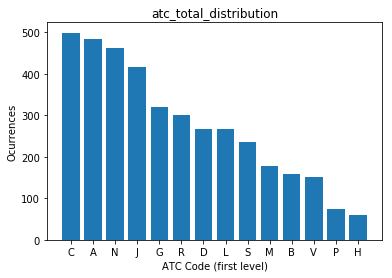

In [33]:
# Distribution of ATC Codes first level of the total set of used drugs
    
all_possible_atc_codes = (list(drug_atc_dict.values()))
    
atc_first_level_all_drugs = list()
for atc_codes in all_possible_atc_codes:
    for atc_code in atc_codes:
        atc_first_level_all_drugs.append(atc_code[0])

print('Total ATC: ', len(atc_first_level_all_drugs))

path_images = './../plots/evaluation/clustering/'

if not (os.path.exists('./../plots/evaluation/clustering/atc_total_distribution.png')):
    save_histogram(atc_first_level_all_drugs, path_images, \
                       'atc_total_distribution')
else: 
    img = Image(filename = path_images + 'atc_total_distribution.png', width=500, height=500)
    display(img)

## AUTOMATIC GENERATION OF FINGERPRINTS

In [3]:
start = time.time()
# Calculate fingerprints
fingerprintsECFP = dict()
fingerprintsMACCS = dict()
for mol in molecules:
    drugbank_id = mol.GetProp('DATABASE_ID')
    fingerprintECFP = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    fingerprintsECFP[drugbank_id] = fingerprintECFP

    fingerprintMACCS = rdkit.Chem.AllChem.GetMACCSKeysFingerprint(mol)
    fingerprintsMACCS[drugbank_id] = fingerprintMACCS

end = time.time()
print("Execution Time (s): " + str(end - start))   

Execution Time (s): 25.305129528045654


In [4]:
print(list(fingerprintsMACCS.values())[1].GetNumBits())

print(list(fingerprintsECFP.values())[1].GetNumBits())

167
1024


## SIMILARITY MATRICES COMPUTATION

Note that the next module can take a lot of time. Actually, the jupyter kernel could die when trying to compute all the simiarity matrices at the same time so it might be a good strategy to compute them independently. Once the files are generated, we can just upload them, however, the first time you download the repository, it is necessary to compute them (every file is around 600MB).

In [5]:
start = time.time()

if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')):
    tanimoto_similarity_matrix_ECFP = similarity_matrix_molecular_structure(fingerprintsECFP, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy',tanimoto_similarity_matrix_ECFP)
else: 
    tanimoto_similarity_matrix_ECFP = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_ECFP.npy')
    
if not(os.path.exists('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')):
    tanimoto_similarity_matrix_MACCS = similarity_matrix_molecular_structure(fingerprintsMACCS, "tanimoto")
    numpy.save('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy',tanimoto_similarity_matrix_MACCS)
else: 
    tanimoto_similarity_matrix_MACCS = numpy.load('./../data/molecular_structure/tanimoto_sim_matrix_MACCS.npy')
    
if not(os.path.exists('./../data/molecular_structure/dice_sim_matrix_ECFP.npy')):
    dice_similarity_matrix_ECFP = similarity_matrix_molecular_structure(fingerprintsECFP, "dice")
    numpy.save('./../data/molecular_structure/dice_sim_matrix_ECFP.npy',dice_similarity_matrix_ECFP)
else: 
    dice_similarity_matrix_ECFP = numpy.load('./../data/molecular_structure/dice_sim_matrix_ECFP.npy')
    
if not(os.path.exists('./../data/molecular_structure/dice_sim_matrix_MACCS.npy')):
    dice_similarity_matrix_MACCS = similarity_matrix_molecular_structure(fingerprintsMACCS, "dice")
    numpy.save('./../data/molecular_structure/dice_sim_matrix_MACCS.npy',dice_similarity_matrix_MACCS)
else: 
    dice_similarity_matrix_MACCS = numpy.load('./../data/molecular_structure/dice_sim_matrix_MACCS.npy')
    
end = time.time()
print("Execution Time (s): " + str(end - start))  

Execution Time (s): 2.11147403717041


In [6]:
# Checking if there is correlation between Dice and Tanimoto coefficients
n = numpy.shape(dice_similarity_matrix_MACCS)[1]
x = numpy.reshape(dice_similarity_matrix_MACCS, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_MACCS, n*n)
c1 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient for MACCS: ", c1[0]) 


n = numpy.shape(dice_similarity_matrix_ECFP)[1]
x = numpy.reshape(dice_similarity_matrix_ECFP, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_ECFP, n*n)
c2 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient for ECFP: ", c2[0]) 

n = numpy.shape(tanimoto_similarity_matrix_ECFP)[1]
x = numpy.reshape(tanimoto_similarity_matrix_ECFP, n*n)
y = numpy.reshape(tanimoto_similarity_matrix_MACCS, n*n)
c3 = scipy.stats.pearsonr(x, y)
print("Pearson Correlation Coefficient for tanimoto: ", c3[0]) 

Pearson Correlation Coefficient for MACCS:  0.9896782493032734
Pearson Correlation Coefficient for ECFP:  0.9908445386353344
Pearson Correlation Coefficient for tanimoto:  0.6009708841666144


## CLUSTERING

In [6]:
# Spectral Clustering
nclust= 14

sca_ECFP = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_ECFP.fit(tanimoto_similarity_matrix_ECFP)

sca_MACCS = SpectralClustering(affinity="precomputed", n_clusters=nclust)
sca_MACCS.fit(tanimoto_similarity_matrix_MACCS)

/home/albertolivares/miniconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=14, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

In [7]:
# Print the clusters for ECFP
clusters_idx_ECFP = label_idx(sca_ECFP.labels_, nclust)

clusters_dbid_ECFP = dict()
for l in clusters_idx_ECFP.keys():
     clusters_dbid_ECFP[l] = idx_to_id(clusters_idx_ECFP[l], ids_dic)
print('Number of clusters: ', nclust)
print('Clusters:\n ', clusters_dbid_ECFP)

Number of clusters:  14
Clusters:
  {0: ['DB00170', 'DB00186', 'DB00190', 'DB00233', 'DB00244', 'DB00250', 'DB00252', 'DB00255', 'DB00259', 'DB00265', 'DB00266', 'DB00310', 'DB00316', 'DB00323', 'DB00336', 'DB00406', 'DB00446', 'DB00498', 'DB00500', 'DB00533', 'DB00545', 'DB00564', 'DB00580', 'DB00605', 'DB00627', 'DB00628', 'DB00629', 'DB00693', 'DB00695', 'DB00729', 'DB00733', 'DB00756', 'DB00765', 'DB00784', 'DB00795', 'DB00818', 'DB00821', 'DB00837', 'DB00842', 'DB00861', 'DB00890', 'DB00909', 'DB00936', 'DB00939', 'DB00945', 'DB00951', 'DB00963', 'DB00968', 'DB00988', 'DB00991', 'DB01010', 'DB01011', 'DB01014', 'DB01018', 'DB01040', 'DB01068', 'DB01115', 'DB01125', 'DB01133', 'DB01144', 'DB01145', 'DB01174', 'DB01204', 'DB01230', 'DB01243', 'DB01250', 'DB01294', 'DB01397', 'DB01399', 'DB01400', 'DB01401', 'DB01418', 'DB01422', 'DB01428', 'DB01435', 'DB01495', 'DB01595', 'DB01599', 'DB01609', 'DB01644', 'DB01645', 'DB01650', 'DB01665', 'DB01671', 'DB01672', 'DB01676', 'DB01688', 'D

In [8]:
# Print the clusters for MACCS
clusters_idx_MACCS = label_idx(sca_MACCS.labels_, nclust)

clusters_dbid_MACCS = dict()
for l in clusters_idx_MACCS.keys():
     clusters_dbid_MACCS[l] = idx_to_id(clusters_idx_MACCS[l], ids_dic)
print('Number of clusters: ', nclust)
print('Clusters:\n ', clusters_dbid_MACCS)

Number of clusters:  14
Clusters:
  {0: ['DB00173', 'DB00205', 'DB00238', 'DB00257', 'DB00272', 'DB00339', 'DB00352', 'DB00382', 'DB00384', 'DB00404', 'DB00413', 'DB00425', 'DB00437', 'DB00440', 'DB00475', 'DB00478', 'DB00484', 'DB00488', 'DB00501', 'DB00518', 'DB00536', 'DB00555', 'DB00564', 'DB00575', 'DB00594', 'DB00609', 'DB00633', 'DB00643', 'DB00683', 'DB00697', 'DB00724', 'DB00730', 'DB00733', 'DB00740', 'DB00744', 'DB00751', 'DB00763', 'DB00821', 'DB00845', 'DB00885', 'DB00897', 'DB00915', 'DB00935', 'DB00951', 'DB00960', 'DB00962', 'DB00964', 'DB00993', 'DB00998', 'DB01006', 'DB01011', 'DB01033', 'DB01043', 'DB01048', 'DB01079', 'DB01087', 'DB01123', 'DB01157', 'DB01213', 'DB01215', 'DB01217', 'DB01247', 'DB01273', 'DB01275', 'DB01422', 'DB01438', 'DB01446', 'DB01447', 'DB01454', 'DB01490', 'DB01509', 'DB01546', 'DB01609', 'DB01636', 'DB01659', 'DB01663', 'DB01665', 'DB01667', 'DB01685', 'DB01705', 'DB01706', 'DB01710', 'DB01725', 'DB01740', 'DB01741', 'DB01767', 'DB01771', 'D

In [7]:
# Dictionary of drugs and their respective atc codes
if not(os.path.exists('./../data/molecular_structure/drug_atc_dict.pkl')):
    zip_filepath = './../corpus/drugbank.xml_release_2017_12_20.zip' # Version 5.0.11
    filename = 'drugbank.xml'

    file = read_zip_file(zip_filepath, filename)
    drug_atc_dict = drugbank_id_atc_dictionary(file)

    save_obj(drug_atc_dict, './../data/molecular_structure/', 'drug_atc_dict')
else:
    drug_atc_dict = load_obj('./../data/molecular_structure/', 'drug_atc_dict')

In [8]:
# Total of drugs within Drugbank
print(len(drug_atc_dict))

10562


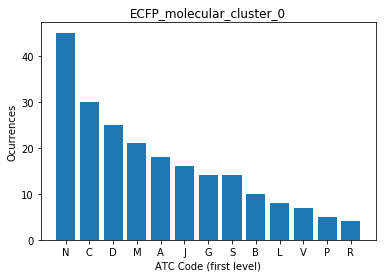

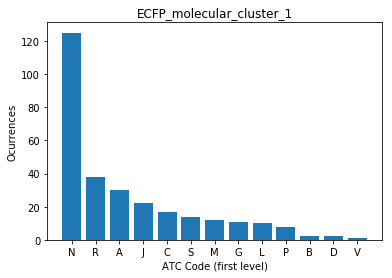

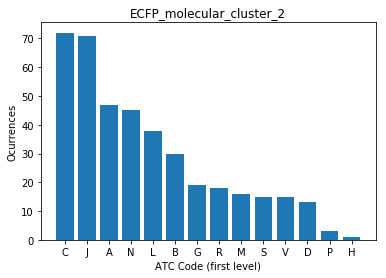

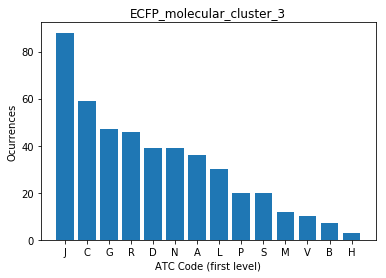

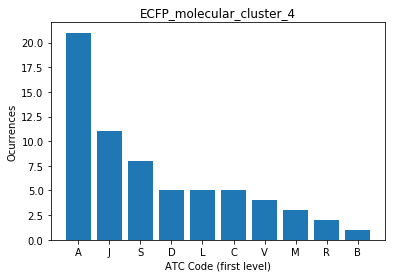

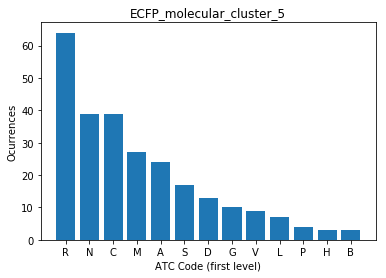

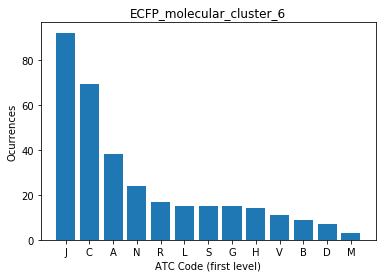

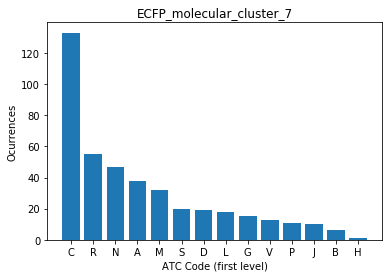

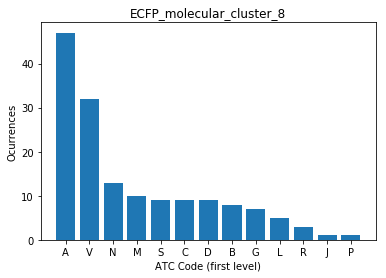

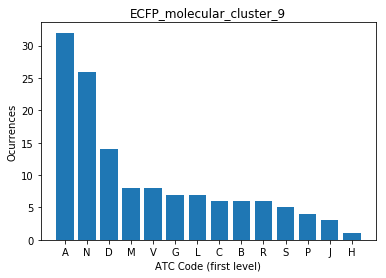

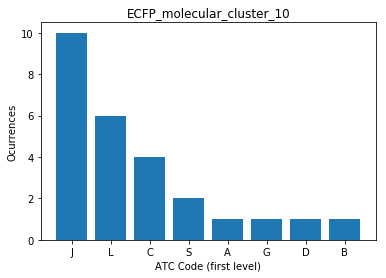

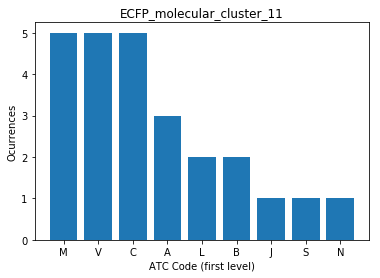

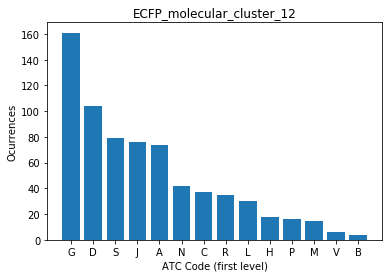

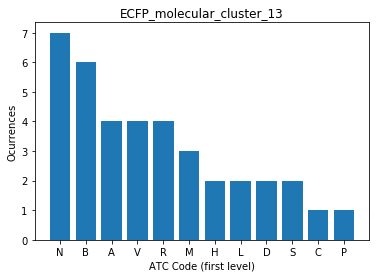

In [11]:
# Clusters ATC code distribution for ECFP
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_ECFP.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = drug_atc_dict[db_id]
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/molecular_structure/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/molecular_structure/ECFP_molecular_cluster_'+str(i)+'.png')):
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'ECFP_molecular_cluster_'+str(i))
    else: 
        img = Image(filename = path_images + 'ECFP_molecular_cluster_'+str(i)+'.png', width=500, height=500)
        display(img)

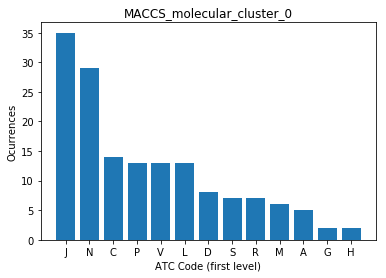

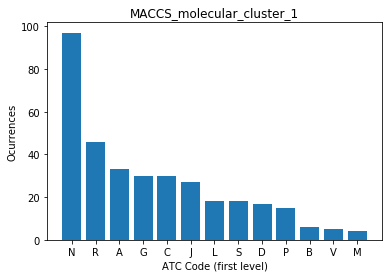

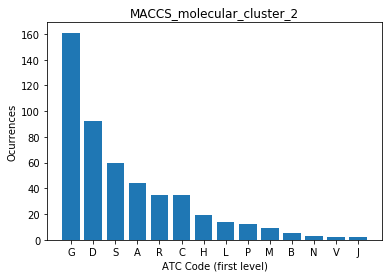

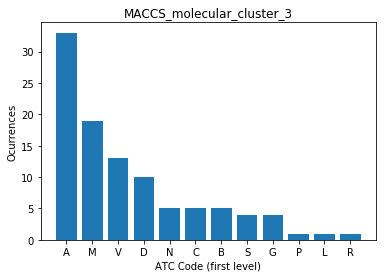

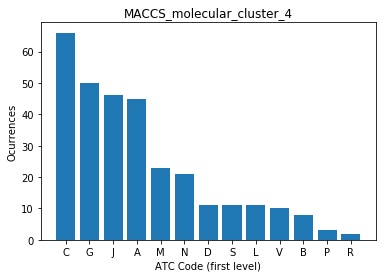

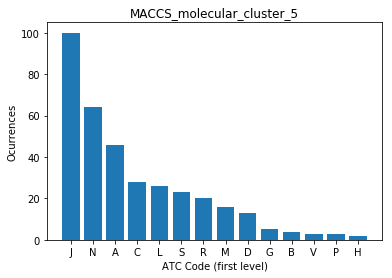

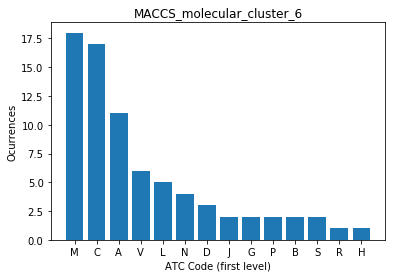

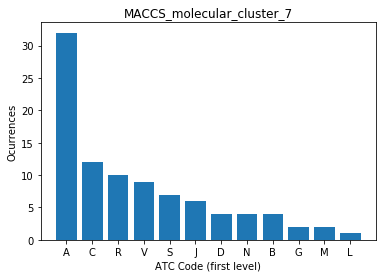

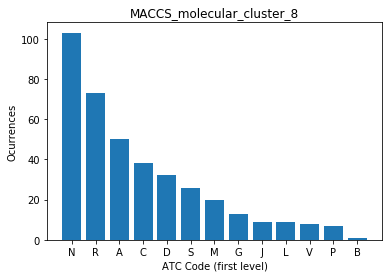

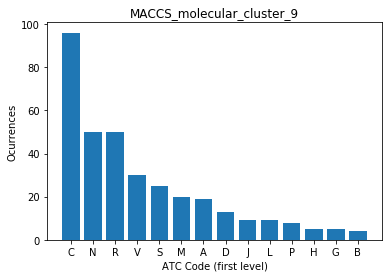

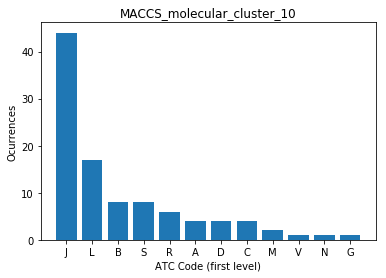

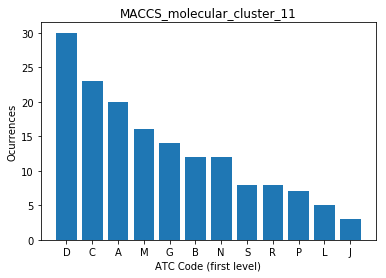

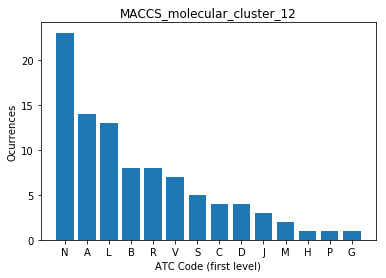

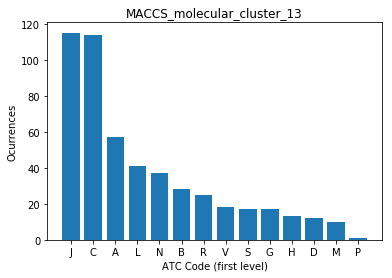

In [12]:
# Clusters ATC code distribution for MACCS
clusters_ATC_distribution = dict()
for cluster, drugbank_ids in clusters_dbid_MACCS.items():
    atc_first_level_for_one_cluster = list()
    for db_id in drugbank_ids:
        atc_codes_dbid = drug_atc_dict[db_id]
        for atc_code in atc_codes_dbid:
            atc_first_level_for_one_cluster.append(atc_code[0])
    clusters_ATC_distribution[cluster] = atc_first_level_for_one_cluster
    
path_images = './../plots/evaluation/clustering/molecular_structure/'

for i in range (0, len(clusters_ATC_distribution)):
    if not(os.path.exists('./../plots/evaluation/clustering/molecular_structure/MACCS_molecular_cluster_'+str(i)+'.png')):
        save_histogram(clusters_ATC_distribution[i], path_images, \
                           'MACCS_molecular_cluster_'+str(i))
    else: 
        img = Image(filename = path_images + 'MACCS_molecular_cluster_'+str(i)+'.png', width=500, height=500)
        display(img)

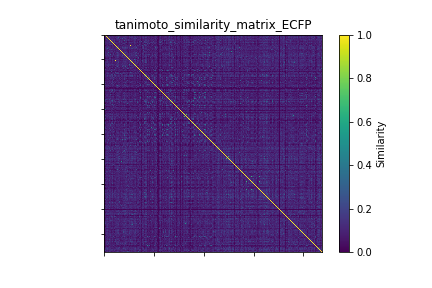

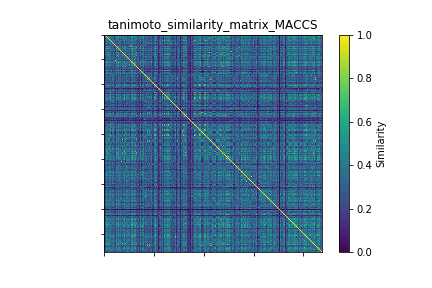

In [17]:
# Visual evaluation of Similarity
path_images = './../plots/molecular_structure/'

if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ECFP.png')):
    save_similarity_matrix(numpy.array(tanimoto_similarity_matrix_ECFP), path_images, \
                       'tanimoto_similarity_matrix_ECFP')
else: 
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ECFP.png", width=500, height=500)
    display(img)
    
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_MACCS.png')):
    save_similarity_matrix(numpy.array(tanimoto_similarity_matrix_MACCS), path_images, \
                       'tanimoto_similarity_matrix_MACCS')
else:
    img = Image(filename = path_images + "tanimoto_similarity_matrix_MACCS.png", width=500, height=500)
    display(img)

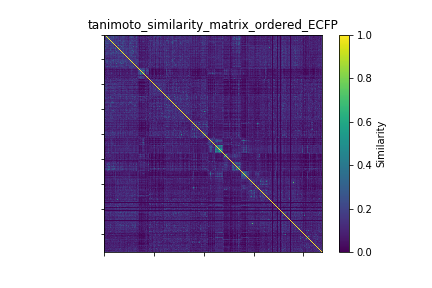

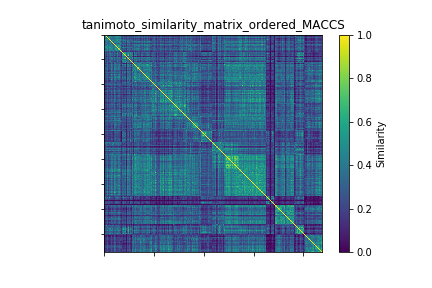

In [20]:
# Order the similarity matrices according to clusters
path_images = './../plots/molecular_structure/'

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_ECFP[i]
    
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ordered_ECFP.png')):
    save_similarity_matrix_ordered(numpy.array(tanimoto_similarity_matrix_ECFP), clusters_idx_ordered, \
                                   path_images, 'tanimoto_similarity_matrix_ordered_ECFP')
else: 
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ordered_ECFP.png", width=500, height=500)
    display(img)

clusters_idx_ordered = list()
for i in range(nclust):
    clusters_idx_ordered += clusters_idx_MACCS[i]
if not(os.path.exists('./../plots/molecular_structure/tanimoto_similarity_matrix_ordered_MACCS.png')):
    save_similarity_matrix_ordered(numpy.array(tanimoto_similarity_matrix_MACCS), clusters_idx_ordered, \
                                   path_images, 'tanimoto_similarity_matrix_ordered_MACCS')
else:
    img = Image(filename = path_images + "tanimoto_similarity_matrix_ordered_MACCS.png", width=500, height=500)
    display(img)

In [13]:
# Extract similarity for a list of pairs from a Similarity Matrix
ground_truth_path = '../data/evaluation/ground_truth.csv'
with open(ground_truth_path, 'rt') as csvfile:
    reader = csv.reader(csvfile)
    ground_truth_list = list(reader)
    
# We add an id for each pair (in order to evaluate afterwards the order infered by the similarity values)
for i in range(0, len(ground_truth_list)):
    ground_truth_list[i].append(i)

computed_ECFP_similarity_list = compute_similarity_between_pairs(ids, tanimoto_similarity_matrix_ECFP, ground_truth_list)
computed_MACCS_similarity_list = compute_similarity_between_pairs(ids, tanimoto_similarity_matrix_MACCS, ground_truth_list)

In [16]:
# Count number of pairs which actually are within our matrix
n = len(computed_ECFP_similarity_list)
counter = 0
for i in range(0, n):
    if computed_ECFP_similarity_list[i][2] == -1:
        counter += 1

In [17]:
print("The total of pairs from the ground truth is: ", n)
print("The number of pairs we have from the total is: ", n - counter) # number of drugs which actually are in our matrix of similarity..

The total of pairs from the ground truth is:  97
The number of pairs we have from the total is:  96


In [18]:
# Here we evaluate two different things, if the order infered by the similarity values is the same in the pairs
# and the correlation among the values of similarities predicted.


# Necessary to not contemplate pairs which are not among our computed similarities (for the order correlation)
computed_ECFP_similarity_list_match = list()
computed_MACCS_similarity_list_match = list()
ground_truth_list_match = list()
for i in range(0, len(computed_ECFP_similarity_list)):
    if not computed_ECFP_similarity_list[i][2] == -1:
        computed_ECFP_similarity_list_match.append(computed_ECFP_similarity_list[i])
        computed_MACCS_similarity_list_match.append(computed_MACCS_similarity_list[i])
        ground_truth_list_match.append(ground_truth_list[i])

ground_truth_list_ordered = sorted(ground_truth_list_match, key=itemgetter(2)) # From 0 to 1 (similarity)
computed_ECFP_similarity_list_ordered = sorted(computed_ECFP_similarity_list_match, key=itemgetter(2))
computed_MACCS_similarity_list_ordered = sorted(computed_MACCS_similarity_list_match, key=itemgetter(2))

print("Correlation (ECFP)")
corr_order = ground_truth_evaluation_order(computed_ECFP_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_ECFP_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_ECFP_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

print("\nCorrelation (MACCS)")
corr_order = ground_truth_evaluation_order(computed_MACCS_similarity_list_ordered, ground_truth_list_ordered)
print("Order", corr_order)
corr_value = ground_truth_evaluation_value(computed_MACCS_similarity_list, ground_truth_list)
print("Value", corr_value)
acc_threshold, recall_threshold = ground_truth_evaluation_threshold(computed_MACCS_similarity_list, ground_truth_list, 0.85)
print("Accuracy, Recall: ",acc_threshold, recall_threshold)

Correlation (ECFP)
Order KendalltauResult(correlation=-0.04035087719298245, pvalue=0.5602953155432291)
Value (0.8885935873368818, 1.404783714471167e-33)
Accuracy, Recall:  0.7708333333333334 0.12

Correlation (MACCS)
Order KendalltauResult(correlation=0.0600877192982456, pvalue=0.3857919467847982)
Value (0.9186495912074873, 1.0912957645863173e-39)
Accuracy, Recall:  0.8854166666666666 0.76


In [10]:
for i in range (0, len(computed_MACCS_similarity_list)):
    print(computed_ECFP_similarity_list[i][2], ground_truth_list[i][2])

0.3877551020408163 0.4688
0.7464788732394366 0.9375
0.2692307692307692 0.1406
0.11688311688311688 0.0313
0.4074074074074074 0.8828
0.11320754716981132 0.0078
0.6808510638297872 0.9055
0.171875 0.0156
0.5777777777777777 0.5669
0.8064516129032258 0.9844
0.16393442622950818 0
0.14285714285714285 0.0078
0.5 0.7421
0.8596491228070176 0.9212
-1 0.5039
0.10526315789473684 0.0078
0.43137254901960786 0.2422
0.6 0.4961
0.10714285714285714 0.0078
0.6 0.9766
0.7333333333333333 0.9453
0.25 0.3937
0.17857142857142858 0.0469
0.12121212121212122 0
0.4576271186440678 0.7953
0.17073170731707318 0.1575
0.21818181818181817 0.0156
0.75 0.9453
0.13157894736842105 0
0.7 0.8359
0.18032786885245902 0.0234
0.4 0.8438
0.37209302325581395 0.25
0.37142857142857144 0.8438
0.13402061855670103 0.0234
0.15942028985507245 0.0547
0.16666666666666666 0.0156
0.42857142857142855 0.875
0.38461538461538464 0.1094
0.631578947368421 0.5827
0.22580645161290322 0.0236
0.30985915492957744 0.8125
0.15625 0.0156
0.5714285714285714 